In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fir_in_buffer import FIRInBuffer
from fir_coef_gen import FIRCoef
from macc import MACC
from seq_fir import FIR 
from decimator import Decimator
from tqdm import tqdm

100%|██████████| 512/512 [1:23:47<00:00,  9.82s/it]


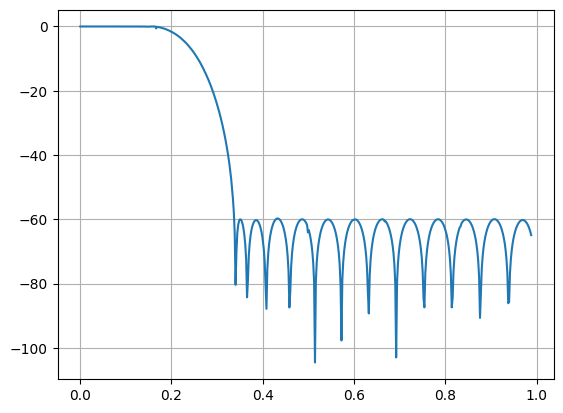

In [2]:
fs = 960e3  # sampling frequency 960 kHz

ts = 1 / fs

freqs_to_scan = np.arange(100, 475e3, (475e3/512))

attenuation_dbs = []

for freq in tqdm(freqs_to_scan):
    
    # sample 1.5 periods of the signal
    signal_length = int(1.5 * (1/freq) * fs)
    signal_length = signal_length if signal_length > 512 else 512

    fir = FIR(exec_path="../../build/exec/cic3d128comp")
    decimator = Decimator(exec_path="../../build/exec/decimator2")
    
    signal = np.sin(2 * np.pi * freq * np.arange(signal_length) * ts, dtype=np.float64) 
    signal_up_sampled = np.zeros(signal_length * 36)
    signal_up_sampled[::36] = signal
    en_signal = np.zeros_like(signal_up_sampled, dtype=bool)
    en_signal[::36] = True

    signal_filtered = np.zeros_like(signal_up_sampled, dtype=np.float64)
    signal_valid    = np.zeros_like(signal_up_sampled, dtype=bool)

    for i, (en, sig) in enumerate(zip(en_signal, signal_up_sampled)):
        valid, data = fir.forward(en, np.float64(sig))
        signal_valid[i], signal_filtered[i] = decimator.forward(valid, data)

    fir.terminate()
    del(fir)
    decimator.terminate()
    del(decimator)
    
    signal_filtered = signal_filtered[signal_valid][64:]

    signal_pp = np.max(signal) - np.min(signal)
    filtered_pp = np.max(signal_filtered) - np.min(signal_filtered)
    attenuation_db = 20 * np.log10(filtered_pp / signal_pp)
    attenuation_dbs.append(attenuation_db)

plt.grid()
plt.plot(freqs_to_scan*2/fs, attenuation_dbs)

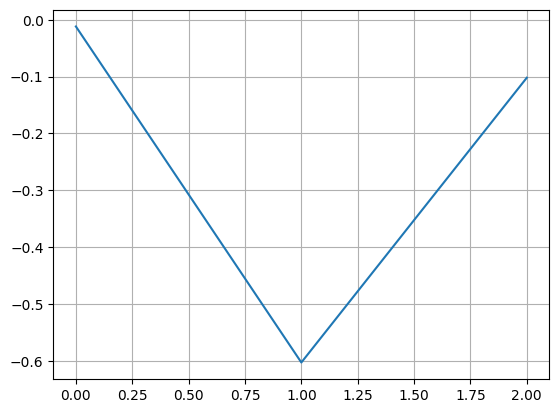

In [12]:
plt.grid()
plt.plot(attenuation_dbs[85:88])

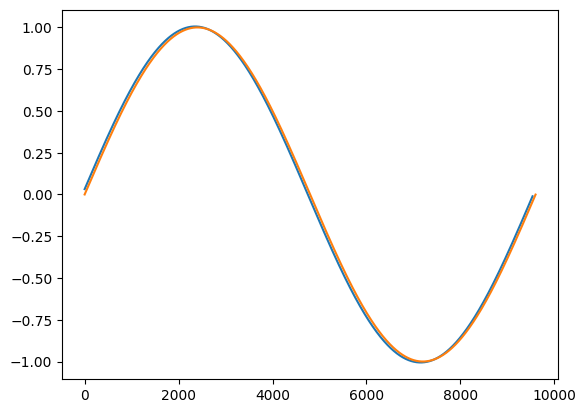

In [33]:
fir = FIR(exec_path="../../build/exec/cic3d128comp")
signal_length = int((1/100) * 960e3)    

signal = np.sin(2 * np.pi * 100 * np.arange(signal_length) * (1/960e3), dtype=np.float64) 
signal_up_sampled = np.zeros(signal_length * 36)
signal_up_sampled[::36] = signal
en_signal = np.zeros_like(signal_up_sampled, dtype=bool)
en_signal[::36] = True
signal_filtered = np.zeros_like(signal_up_sampled, dtype=np.float64)
signal_valid    = np.zeros_like(signal_up_sampled, dtype=bool)
for i, (en, sig) in enumerate(zip(en_signal, signal_up_sampled)):
    signal_valid[i], signal_filtered[i] = fir.forward(en, np.float64(sig))
fir.terminate()
del(fir)

signal_filtered = signal_filtered[signal_valid][64:]

plt.plot(signal_filtered)
plt.plot(signal)

np.float64(128.0)

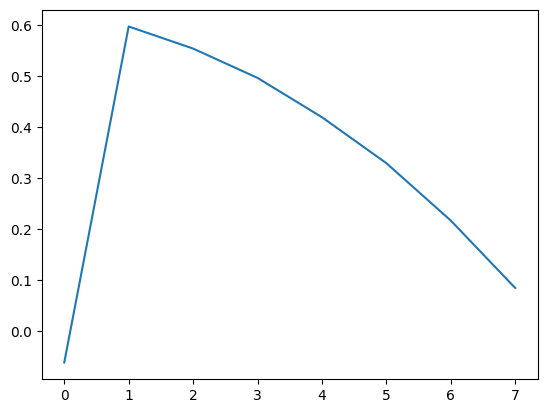

In [22]:
plt.plot(attenuation_dbs[62:70])
freqs_to_scan[62]

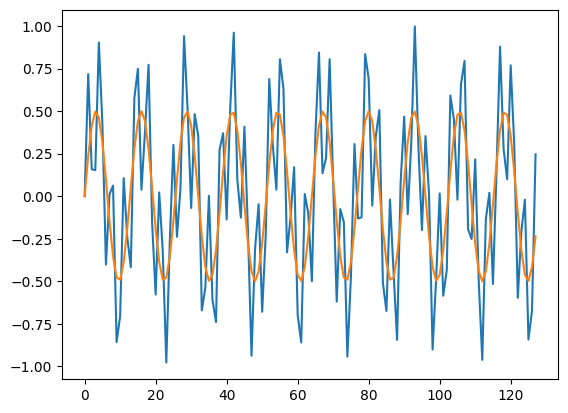

In [2]:
signal_length = 128

fs = 1024  # sampling frequency 1024 Hz

ts = 1 / fs  # sampling interval

# egnerate a sine wave signal with frequency of 300 Hz / 0.3fs
signal_h = np.sin(2 * np.pi * 300 * np.arange(signal_length) * ts)

# egnerate a sine wave signal with frequency of 80 Hz / 0.08fs
signal_l = np.sin(2 * np.pi * 80 * np.arange(signal_length) * ts)

signal = (signal_h + signal_l) * 0.5

plt.plot(signal)
plt.plot(signal_l * 0.5)

In [3]:
signal_up_sampled = np.zeros(signal_length * 32)
signal_up_sampled[::32] = signal
rst_signal = np.zeros_like(signal_up_sampled, dtype=bool)
rst_signal[2::32] = True # reset signal for every 32 samples with a delay of 3 cycles (from macc latency)

en_signal = np.zeros_like(signal_up_sampled, dtype=bool)
en_signal[::32] = True

fir_coef = FIRCoef(exec_path="../../build/exec/lpfCoef01025Prog")
fir_buffer = FIRInBuffer(exec_path="../../build/exec/firInBuffer")
fir_macc = MACC(exec_path="../../build/exec/maccProg")

signal_sampled = np.zeros_like(signal_up_sampled, dtype=np.uint32)
coef_sampled   = np.zeros_like(signal_up_sampled, dtype=np.uint32)
macc_output    = np.zeros_like(signal_up_sampled, dtype=np.uint64)
signal_filtered = np.zeros(signal_length, dtype=np.float64)

for i, (en, sig, rst) in enumerate(zip(en_signal, signal_up_sampled, rst_signal)):
    signal_sampled[i] = fir_buffer.forward(en, np.uint32(np.int32(sig * (2**17 - 1))))
    coef_sampled[i]   = fir_coef.forward(en)
    macc_output[i]    = fir_macc.forward(rst, signal_sampled[i], coef_sampled[i])

signal_filtered = (signal_sampled.astype(np.int32).astype(np.float64) / (2**17 - 1)) * (coef_sampled.astype(np.int32).astype(np.float64) / (2**17 - 1))
signal_filtered = signal_filtered.reshape(-1, 32)
signal_filtered = np.sum(signal_filtered, axis=1)

#plt.plot(signal_up_sampled)
#plt.plot(np.arange(0, len(signal_up_sampled), 32), signal[:])
#plt.plot(np.arange(31, len(signal_up_sampled), 32), signal_sampled[31:len(signal_up_sampled):32] / (2**17 - 1))

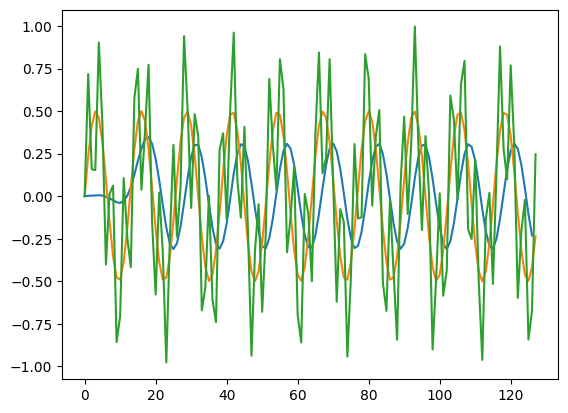

In [4]:
plt.plot(macc_output.astype(np.int64)[31+3::32] / ((2**34 - 1)))  # macc latency is 3 cycles
plt.plot(signal_l * 0.5)
plt.plot(signal)

(np.int64(31), np.float64(0.00026542121528436375))

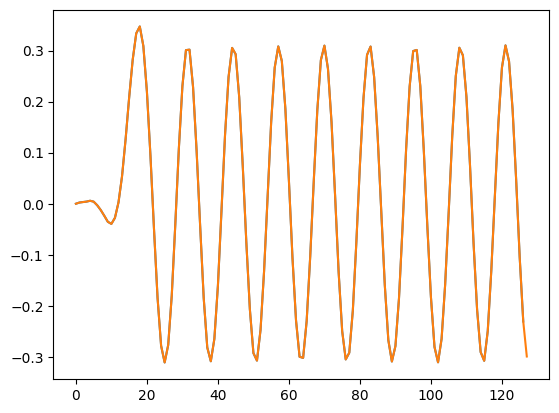

In [5]:
filtered = macc_output.astype(np.int64)[31+3::32] / ((2**34 - 1))

plt.plot(filtered)  # macc latency is 3 cycles

plt.plot(signal_filtered)  # macc latency is 3 cycles

errs = []
for l in range(50):
    sig1 = macc_output.astype(np.int64)[l+3::32] / ((2**34 - 1))
    sig2 = signal_filtered
    err = np.sum(np.abs((sig1[:100] - sig2[:100])))
    errs.append(err)

np.where(errs == np.min(errs))[0][0], errs[np.where(errs == np.min(errs))[0][0]]


100%|██████████| 254/254 [25:17<00:00,  5.98s/it]


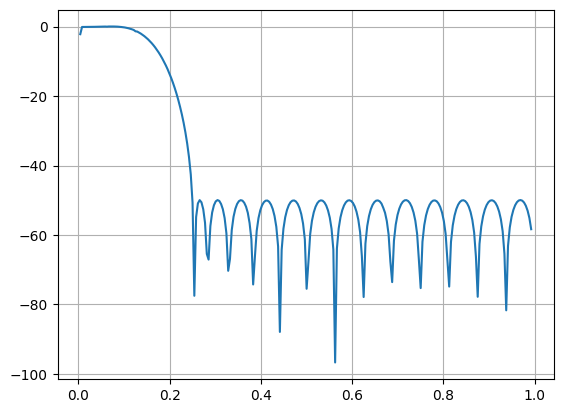

In [6]:
signal_length = 256
freqs_to_scan = np.arange(0, fs/2, fs/512)[1:-1]

attenuation_dbs = []

for freq in tqdm(freqs_to_scan):
    fir_coef   = FIRCoef(exec_path="../../build/exec/lpfCoef01025Prog")
    fir_buffer = FIRInBuffer(exec_path="../../build/exec/firInBuffer")
    fir_macc   = MACC(exec_path="../../build/exec/maccProg")

    signal = np.sin(2 * np.pi * freq * np.arange(signal_length) * ts) 
    signal_up_sampled = np.zeros(signal_length * 32)
    signal_up_sampled[::32] = signal
    en_signal = np.zeros_like(signal_up_sampled, dtype=bool)
    en_signal[::32] = True
    rst_signal = np.zeros_like(signal_up_sampled, dtype=bool)
    rst_signal[2::32] = True # reset signal for every 32 samples with a delay of 2 cycles (from macc latency)

    signal_filtered = np.zeros_like(signal_up_sampled, dtype=np.uint64)

    for i, (en, sig, rst) in enumerate(zip(en_signal, signal_up_sampled, rst_signal)):
        signal_sampled     = fir_buffer.forward(en, np.uint32(np.int32(sig * (2**17 - 1))))
        coef_sampled       = fir_coef.forward(en)
        signal_filtered[i] = fir_macc.forward(rst, signal_sampled, coef_sampled)

    signal_filtered = signal_filtered.astype(np.int64)[31+3::32] / ((2**34 - 1))  # macc latency is 3 cycles

    signal_pp = np.max(signal) - np.min(signal)
    filtered_pp = np.max(signal_filtered[64:]) - np.min(signal_filtered[64:])
    attenuation_db = 20 * np.log10(filtered_pp / signal_pp)
    attenuation_dbs.append(attenuation_db)

plt.grid()
plt.plot(freqs_to_scan*2/fs, attenuation_dbs)

In [8]:
rst_signal[:5]


array([False, False,  True, False, False])